In [1]:
import os
import numpy as np
import graspy as gs
from scipy.stats import truncnorm

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import check_X_y

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed

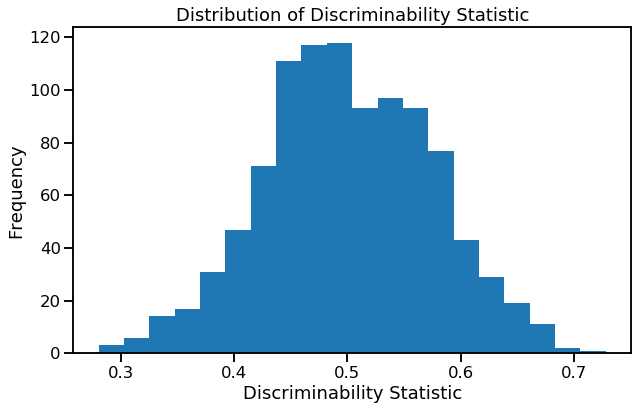

In [2]:
def discr_stat(
    X, Y, dissimilarity="euclidean", remove_isolates=True, return_rdfs=False
):
    """
    Computes the discriminability statistic.
    Parameters
    ----------
    X : array, shape (n_samples, n_features) or (n_samples, n_samples)
        Input data. If dissimilarity=='precomputed', the input should be the dissimilarity matrix.
    Y : 1d-array, shape (n_samples)
        Input labels.
    dissimilarity : str, {"euclidean" (default), "precomputed"}
        Dissimilarity measure to use:
        - 'euclidean':
            Pairwise Euclidean distances between points in the dataset.
        - 'precomputed':
            Pre-computed dissimilarities.
    remove_isolates : bool, optional, default=True
        Whether to remove data that have single label.
    return_rdfs : bool, optional, default=False
        Whether to return rdf for all data points.
    Returns
    -------
    stat : float
        Discriminability statistic.
    rdfs : array, shape (n_samples, max{len(id)})
        Rdfs for each sample. Only returned if ``return_rdfs==True``.
    """
    check_X_y(X, Y, accept_sparse=True)

    uniques, counts = np.unique(Y, return_counts=True)
    if (counts != 1).sum() <= 1:
        msg = "You have passed a vector containing only a single unique sample id."
        raise ValueError(msg)
    if remove_isolates:
        idx = np.isin(Y, uniques[counts != 1])
        labels = Y[idx]

        if dissimilarity == "euclidean":
            X = X[idx]
        else:
            X = X[np.ix_(idx, idx)]
    else:
        labels = Y

    if dissimilarity == "euclidean":
        dissimilarities = euclidean_distances(X)
    else:
        dissimilarities = X

    rdfs = _discr_rdf(dissimilarities, labels)
    stat = np.nanmean(rdfs)

    if return_rdfs:
        return stat, rdfs
    else:
        return stat


def _discr_rdf(dissimilarities, labels):
    """
    A function for computing the reliability density function of a dataset.

    Parameters
    ----------
    dissimilarities : array, shape (n_samples, n_features) or (n_samples, n_samples)
        Input data. If dissimilarity=='precomputed', the input should be the
        dissimilarity matrix.

    labels : 1d-array, shape (n_samples)
        Input labels.

    Returns
    -------
    out : array, shape (n_samples, max{len(id)})
        Rdfs for each sample. Only returned if ``return_rdfs==True``.
    """
    check_X_y(dissimilarities, labels, accept_sparse=True)

    rdfs = []
    for i, label in enumerate(labels):
        di = dissimilarities[i]

        # All other samples except its own label
        idx = labels == label
        Dij = di[~idx]

        # All samples except itself
        idx[i] = False
        Dii = di[idx]

        rdf = [1 - ((Dij < d).sum() + 0.5 * (Dij == d).sum()) / Dij.size for d in Dii]
        rdfs.append(rdf)

    out = np.full((len(rdfs), max(map(len, rdfs))), np.nan)
    for i, rdf in enumerate(rdfs):
        out[i, : len(rdf)] = rdf

    return out


def sample_data(subjects=10, trials=2, nodes=10, win_length=10, total_length=100,
                step_size=10, minimum=-1, maximum=1, seed=None):
    if seed is not None:
        np.random.seed(seed)

    measurements = []
    times = list(np.arange(0, total_length - win_length + 1, step_size))
    time_steps = len(times)
    for j in range(subjects):
        # Truncated normal distribution with mean 0, variance 1, range[-1,1]
        A = truncnorm.rvs(-1, 1, size=nodes)  # MAR(1) coefficient matrix
        for s in range(trials):
            # Simulate time series for each trial
            X = np.zeros((nodes, total_length))
            X0 = np.random.uniform(-1, 1, size=nodes)
            X[:, 0] = X0
            for i in range(np.size(X, 1) - 1):
                epsilon = np.random.normal(size=nodes)
                X[:, i + 1] = A * X[:, i] + epsilon

            # phi = np.random.uniform(-1,1)
            # ar = np.array([1, -phi])
            # ma = np.array([1])
            # generator = ArmaProcess(ar, ma)
            # X = generator.generate_sample((nodes, total_length), axis=1)

            # Calculate correlation matrix with sliding window mwthod
            features = []

            for i, t in enumerate(times):
                corr_matrix = np.corrcoef(X[:, t:t + step_size])
                features.append(corr_matrix[np.triu_indices(nodes, 1)].flatten())
            measurements.append(np.asarray(features).flatten())

    measurements = np.asarray(measurements)
    # subjects*trials measurements in total
    labels = np.repeat(np.arange(1, subjects + 1), trials)

    return measurements, labels


def compute_shuffeled_discr(X, Y):
    np.random.shuffle(Y)

    return discr_stat(X, Y)


def compute_discr_and_test(X, Y, r=100, dissimilarity="euclidean"):
    """
    Compute DISCR and run one sample permutation test.
    Parameters
    ----------
    X : array, shape (n_samples, n_features) or (n_samples, n_samples)
        Input data. If dissimilarity=='precomputed', the input should be the dissimilarity matrix.
    Y : 1d-array, shape (n_samples)
        Input labels.
    r : int
        Number of permutations
    dissimilarity : str, {"euclidean" (default), "precomputed"}
        Dissimilarity measure to use:
        - 'euclidean':
            Pairwise Euclidean distances between points in the dataset.
        - 'precomputed':
            Pre-computed dissimilarities.

    Returns
    -------
    p_value : float
        p value.
    discr_sample : float
        Discriminability statistic.

    """
    discr_sample = discr_stat(X, Y, dissimilarity=dissimilarity)
    discr_shuffeled = Parallel(8, verbose=0)(delayed(compute_shuffeled_discr)(X, Y) for _ in range(r))
    p_value = (np.sum(discr_shuffeled >= discr_sample)+1)/(r+1)

    return p_value, discr_sample


def run_exp():
    x, y = sample_data()
    p, stat = compute_discr_and_test(x, y)

    return p, stat


par = Parallel(56, verbose=0)
res = par(delayed(run_exp)() for _ in range(1000))
p_values = np.asarray(res)[:,0]
discr_stats = np.asarray(res)[:,1]

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.hist(discr_stats, 20)
    ax.set_title("Distribution of Discriminability Statistic")
    ax.set_xlabel("Discriminability Statistic")
    ax.set_ylabel("Frequency")